In [1]:
import rosbag
import cv2
import numpy as np
from tqdm import tqdm
import bisect
from loguru import logger
import matplotlib.pyplot as plt
from converter import UTMtoLL, LLtoUTM
import os

In [2]:
bag = rosbag.Bag('/mnt/UNENCRYPTED/ruichend/seq/dry_run_1/dry_run_1.bag')
gps_fixed_msgs = []
for topic, msg, t in bag.read_messages(topics=['/mavros/global_position/raw/fix']):
    gps_fixed_msgs.append(msg)

In [3]:
_, gt_e, gt_n = LLtoUTM(23, 39.9411551, -75.1987216)

In [4]:
def extract_lat_lon_from_file(file_path):
    lat, lon = None, None
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('latitude:'):
                lat = float(line.strip().split(':')[1])
            elif line.strip().startswith('longitude:'):
                lon = float(line.strip().split(':')[1])
    return [lat, lon] if lat is not None and lon is not None else None

def read_all_casualty_coords(directory):
    coords = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            lat_lon = extract_lat_lon_from_file(file_path)
            if lat_lon:
                coords.append(lat_lon)
    return coords

# Example usage:
directory_path = '/mnt/UNENCRYPTED/ruichend/seq/dry_run_1/GT'
casualty_gps = np.array(read_all_casualty_coords(directory_path))
casualty_coords = np.array([LLtoUTM(23, lat, lon) for lat, lon in casualty_gps])[:, 1:3].astype(np.float32)  # Extracting easting and northing

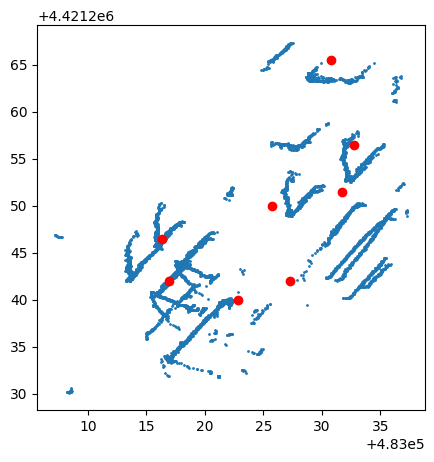

In [5]:
april = np.load('./logs/dry_run_1.npy')
# april = april[: len(april) // 2, :2]  # Take only the first half of the data
plt.figure(figsize=(5, 5))
plt.scatter(april[:, 1], april[:, 0], label='AprilTag', s=1)
plt.scatter(casualty_coords[:, 0], casualty_coords[:, 1], label='Ground Truth', color='red')

In [10]:
gt = np.array([gt_n, gt_e])
april_ne = april[:, :2]
err = np.linalg.norm(gt - april_ne, axis=1)
plt.scatter(np.linspace(0, len(err), len(err)), err, s = 1, label='Error')

NameError: name 'gt_n' is not defined

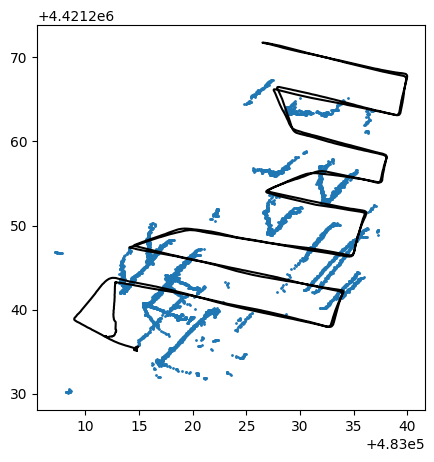

In [16]:
xyz = []

for msg in gps_fixed_msgs:
    lon, lat = msg.longitude, msg.latitude
    _, easting, northing = LLtoUTM(23, lat, lon)
    # xyz.append(
    #     [msg.longitude, msg.latitude, msg.altitude]
    # )
    xyz.append(
        [easting, northing, msg.altitude]
    )
    

xyz = np.array(xyz)



plt.figure(figsize=(5, 5))
plt.plot(xyz[:, 0], xyz[:, 1], c='k')
plt.scatter(april[:, 1], april[:, 0], s=1)
# plt.xlim(xyz[:, 0].min(), xyz[:, 0].max())
# plt.ylim(xyz[:, 1].min(), xyz[:, 1].max())
# plt.xlim(-75.1995, -75.1980)
# plt.ylim(39.9408, 39.94125)
# plt.scatter(gt_n, gt_e, label='Ground Truth', color='red')

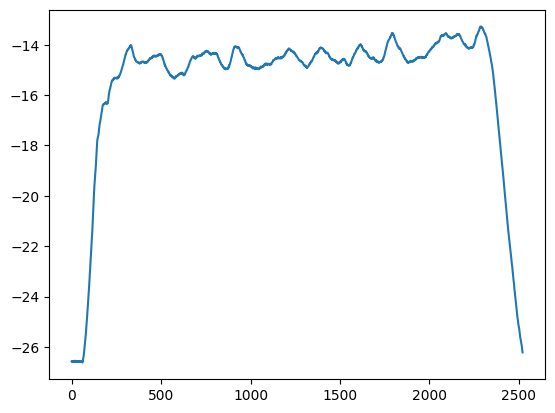

In [15]:
# plt.figure(plt.figure(figsize=(10, 10)))
plt.plot(xyz[:, 2])

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
ang = np.pi * 15 / 180

In [25]:
R = np.array([
    [np.cos(ang), -np.sin(ang)],
    [np.sin(ang), np.cos(ang)]
])

In [26]:
rotated = R @ np.array([-11, -26]).reshape(-1, 1)

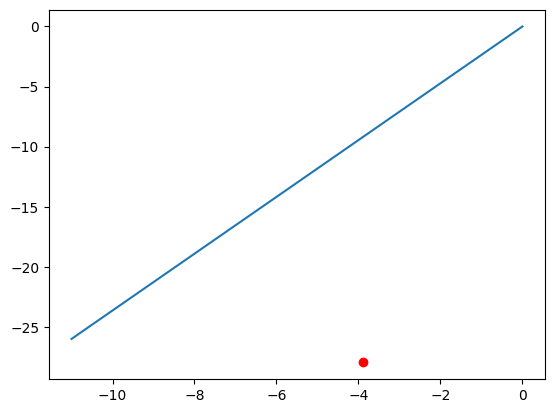

In [27]:
plt.plot([0, -11], [0, -26])
plt.scatter(rotated[0], rotated[1], c='r')

In [28]:
np.linalg.norm(rotated)

28.23118842698621

In [29]:
np.dot([-11, -26], rotated)/ np.linalg.norm(rotated)**2

array([0.96592583])

In [30]:
np.cos(ang)

0.9659258262890684

In [31]:
rotated.flatten()

array([ -3.89588892, -27.96108098])

In [32]:
rotated = rotated.flatten()

In [36]:
np.hstack((rotated, [1]))

array([ -3.89588892, -27.96108098,   1.        ])

In [19]:
import numpy as np

class UAVCalibration:
    """Calibration parameters for the UAV.
    
    Body frame is in the same orientation as  the IMU frame but with an offset.
    """
    def __init__(self):
        self.T_ci = np.array([
            [ 0.011106298412152327,  0.9999324199187616,  0.0034359468839849595, 0.036802732375442404],
            [-0.999832733821092,  0.01115499451474039,  -0.014493808237225339,  -0.008332238900780303],
            [-0.014531156713131006 , -0.0032743996068676073, 0.9998890557415823,  -0.08775357009176091],
            [ 0.        ,  0.        ,  0.        ,  1.        ],
        ])
        self.R_ci = self.T_ci[:3, :3]
        self.R_ic = self.R_ci.T  # Rotation: camera to IMU
        self.t_imu2cam = self.T_ci[:3, 3]  # Translation from IMU to camera in camera frame
        self.t_body2imu = np.array([-0.0389588892, 0, -0.2796108098])  # body to IMU in IMU frame
        self.t_imu2body = -self.t_body2imu  # IMU to body in body frame
        # self.t_imu2body = np.array([11.0, 0.0, 26.0])  # IMU to body in body frame
        self.t_body2cam = (self.T_ci @ np.hstack((self.t_body2imu, [1])).reshape(-1, 1)).flatten()[:3]  # body to camera in camera frame
        self.t_body2cam_imu = (self.R_ic @ self.t_body2cam.reshape(-1, 1)).flatten()  # body to camera in IMU frame
        # self.t_cam2body = -(self.R_ic @ self.t_imu2cam.reshape(-1, 1)).flatten()  # camera to body in IMU/body frame
        self.t_cam2body = -self.t_body2cam_imu
        
    def get_alt_cam(self, alt_body, R_wi):
        """
        Get the altitude of the camera in the world frame.
        :param alt_body: Altitude in body frame.
        :param R_wi: Rotation from world to IMU frame.
        :return: Altitude of the camera in the world frame.
        """
        alt_offset = (R_wi @ self.t_body2cam_imu.reshape(-1, 1)).flatten()[-1]
        assert alt_offset <= 0, "Drone upside down?"
        alt_cam = alt_body + (R_wi @ self.t_body2cam_imu.reshape(-1, 1)).flatten()[-1]
        return alt_cam

In [20]:
calib = UAVCalibration()

In [21]:
calib.t_imu2cam

array([ 0.03680273, -0.00833224, -0.08775357])

In [22]:
calib.t_body2cam_imu

array([-0.02894414,  0.03699464, -0.36710743])

In [23]:
calib.t_body2cam

array([ 0.03540932,  0.03467276, -0.36676724])

In [24]:
calib.t_body2imu

array([-0.03895889,  0.        , -0.27961081])

In [26]:
calib.t_cam2body

array([ 0.02894414, -0.03699464,  0.36710743])

In [28]:
calib.t_imu2body

array([ 0.03895889, -0.        ,  0.27961081])

In [32]:
calib.t_imu2cam

array([ 0.03680273, -0.00833224, -0.08775357])